In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, balanced_accuracy_score,precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, confusion_matrix,matthews_corrcoef
import sys 
import pickle
from rdkit import Chem
from rdkit.Chem import AllChem
from imblearn.under_sampling import RandomUnderSampler
sys.path.append('/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/')
from RF_atomver import *
from VisUtils import *

In [27]:
def scaled_df_with_folds(file_path, file_name, fold):
    """Standard Scalar to normalize original dataset
    Scale data, put back feature names (including ID columns, add subset (train / test) column
    file_path: directory where file is located 
    file_name: should be NEK#_1_uM_min_50_pct_(binding/inhibition)_5fold_random_imbalanced.csv
    returns: final scaled dataframe
    """
    df_original = pd.read_csv(file_path+file_name)
    print(f'original shape: {df_original.shape}')
    df_original = df_original.drop_duplicates(subset='base_rdkit_smiles')
    print(f'remove duplicates: {df_original.shape}')

    id_cols = ['compound_id', 'base_rdkit_smiles', 'fold'] 
    active_col = ['active'] 
    exclude_cols = id_cols +active_col
    feature_cols = [col for col in df_original.columns if col not in exclude_cols]
    # feature_names = df_original.columns.difference(exclude_cols)
    
    original_cols = df_original.columns 
    og_cols = original_cols.to_list() 
    # feature_cols = og_cols[3:-1] 
    id_col_names = og_cols[0:2]
    id_cols = df_original[id_col_names]
    fold_col = df_original['fold']
    true_labels = df_original['active']
    # print(f'all cols: {original_cols.shape}, features: {len(feature_cols)}, id: {id_col_names}')
    
    train_df = df_original[df_original['fold']!=fold]
    test_df = df_original[df_original['fold']==fold]
    trainX_df = train_df[feature_cols]
    testX_df = test_df[feature_cols]
    trainy_df = train_df['active']
    testy_df = test_df['active']
    
    train_id_df = train_df[id_col_names]
    test_id_df = test_df[id_col_names]
    train_fold = train_df['fold']
    test_fold = test_df['fold']
    
    x_df = pd.concat([trainX_df, testX_df])
    scaling=StandardScaler()
    scaling.fit(x_df) 
    
    scaled_data=scaling.transform(x_df)
    trainX_scaled = scaling.transform(trainX_df)
    testX_scaled = scaling.transform(testX_df) 
    print(f'train X: {trainX_scaled.shape}, testX: {testX_scaled.shape}')
    trainX_final = pd.DataFrame(trainX_scaled, columns=feature_cols)
    trainX_final['subset'] = 'train'
    
    testX_final = pd.DataFrame(testX_scaled, columns=feature_cols)
    testX_final['subset']='test'
    trainX_final[id_col_names] = train_id_df.reset_index(drop=True)
    testX_final[id_col_names] = test_id_df.reset_index(drop=True)
    trainX_final['fold'] = train_fold.reset_index(drop=True)
    testX_final['fold'] = test_fold.reset_index(drop=True)
    
    trainX_final['active'] = trainy_df.reset_index(drop=True)
    testX_final['active'] = testy_df.reset_index(drop=True)

    final_df = pd.concat([trainX_final, testX_final], ignore_index=True)
    return final_df
    

In [28]:
def undersample(file_path, filename):
    """Undersample the datasetes using the RandomUndersampler
    Keeps the feature names and id cols
    file_name (full/absolute path): use the scaled dataframe we just created above 'NEK#_binding_moe_scaled_df.csv'
    returns: undersampled dataframe
    """
    
    df = pd.read_csv(file_path+filename)
    original_cols = df.columns.to_list() 
    id_cols = ['compound_id', 'base_rdkit_smiles', 'fold'] 
    active_col = ['active'] 
    exclude_cols = id_cols +active_col
    # feature_names = df.columns.difference(exclude_cols)
    feature_names = [col for col in df.columns if col not in exclude_cols]
    # feature_names = original_cols[0:-5]
    other_cols = original_cols[-5:]
    id_col_names = other_cols[0:4]
    id_cols = df[id_col_names]
    
    train_df = df[df['subset'] == 'train']
    test_df = df[df['subset'] == 'test']
    trainX = train_df[feature_names]
    testX = test_df[feature_names]
    trainy = train_df['active']
    testy = test_df['active']
    
    train_ids = train_df[id_col_names]
    test_ids = test_df[id_col_names]
    undersample = RandomUnderSampler(random_state=42)
    
    trainX_temp, trainy_temp = undersample.fit_resample(trainX.to_numpy(), trainy.to_numpy().reshape(-1))
    
    trainX_resamp = pd.DataFrame(trainX_temp, columns=feature_names)
    trainy_resamp = pd.DataFrame(trainy_temp, columns=['active'])
    
    train_ids_resamp = train_ids.iloc[trainX_resamp.index].reset_index(drop=True)
    train_resamp= pd.concat([train_ids_resamp, trainX_resamp,trainy_resamp], axis=1)
    train_resamp['subset'] = 'train'

    test_df_final = pd.concat([test_ids.reset_index(drop=True),testX.reset_index(drop=True),testy.reset_index(drop=True)],axis=1)
    test_df_final['subset'] = 'test'
    final_df = pd.concat([train_resamp,test_df_final]).reset_index(drop=True)
    return final_df 
        

In [42]:
def smiles_to_fps(smiles_list, radius=2, nBits=2048):
    fps = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
            arr = np.zeros((1,), dtype=np.int8)
            Chem.DataStructs.ConvertToNumpyArray(fp, arr)
            fps.append(arr)
    return np.array(fps)

def make_smiles(file_path, filename):
    """Create Morgan Fingerpint features from smiles srrings 
    file_path: directory of datafame
    filename: any dataframe with active, base_rdkit_smiles, fold, compound_id
    returns: final dataframe with morgan fingerprints based on the original dataframe's smiles strings 
    """
    df = pd.read_csv(file_path+filename)
    train_y = df[df['subset']=='train']['active']
    test_y=df[df['subset']=='test']['active']
    train_sm = df[df['subset']=='train']['base_rdkit_smiles']
    test_sm = df[df['subset']=='test']['base_rdkit_smiles']
    train_id = df[df['subset']=='train']['compound_id']
    test_id = df[df['subset']=='test']['compound_id']
    train_fold = df[df['subset']=='train']['fold']
    test_fold = df[df['subset']=='test']['fold']
    
    trainX_mfp = smiles_to_fps(train_sm, radius=2)
    testX_mfp = smiles_to_fps(test_sm, radius=2)
    
    trainX_mfp_df = pd.DataFrame(trainX_mfp)
    testX_mfp_df = pd.DataFrame(testX_mfp)
    
    trainX_mfp_df['subset'] = 'train'
    testX_mfp_df['subset'] = 'test'
    
    trainX_mfp_df['base_rdkit_smiles'] = train_sm.reset_index(drop=True)
    testX_mfp_df['base_rdkit_smiles'] = test_sm.reset_index(drop=True)
    trainX_mfp_df['compound_id'] = train_id.reset_index(drop=True)
    testX_mfp_df['compound_id'] = test_id.reset_index(drop=True)
    trainX_mfp_df['fold'] = train_fold.reset_index(drop=True)
    testX_mfp_df['fold'] = test_fold.reset_index(drop=True)
    
    trainX_mfp_df['active'] = train_y.reset_index(drop=True)
    testX_mfp_df['active'] = test_y.reset_index(drop=True)
    final_df = pd.concat([trainX_mfp_df,testX_mfp_df], ignore_index=True)
    return final_df
        

In [130]:
data_dir = '/Users/jayceepang/msse/capstone/data/NEK_ATOM_data/'
this_dir = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/undersampler_validation/idea5_dir/'
neks = ['2','3','5','9']
folds = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5']
for i, nek in enumerate(neks):
    if nek in ['2','9']: 
        bind_inhib = ['binding', 'inhibition']
    else: 
        bind_inhib = ['binding'] 
    for bi in bind_inhib: 
        if bi == 'binding': 
            this_bi = 'bind'
        else: 
            this_bi = 'inhib' 
        nek_path= f'{data_dir}NEK{nek}/'
        assay_file = f'NEK{nek}_1_uM_min_50_pct_{bi}_5fold_random_imbalanced.csv'
        print(nek, bi)
        for fold in folds: 
            final_df = scaled_df_with_folds(nek_path,assay_file, fold) 

            fold_dir = f'{this_dir}{fold}/'
            final_csv_name = f'NEK{nek}_{bi}_moe_scaled_df_{fold}.csv'
            final_mfp_csv_name= f'NEK{nek}_{bi}_mfp_scaled_df_{fold}.csv'
            final_df.to_csv(f'{fold_dir}{final_csv_name}', index=False)
            mfp_df = make_smiles(fold_dir, final_csv_name)
            mfp_df.to_csv(f'{fold_dir}{final_mfp_csv_name}', index=False)
            
            under_df = undersample(fold_dir, final_csv_name)
            
            under_df.to_csv(f'{fold_dir}NEK{nek}_{bi}_moe_UNDER_df_{fold}.csv',index=False)
            under_mfp_df = make_smiles(fold_dir, f'NEK{nek}_{bi}_moe_UNDER_df_{fold}.csv')
            under_mfp_df.to_csv(f'{fold_dir}NEK{nek}_{bi}_mfp_UNDER_df_{fold}.csv',index=False)

2 binding
original shape: (1408, 310)
remove duplicates: (1408, 310)
train X: (1125, 306), testX: (283, 306)
original shape: (1408, 310)
remove duplicates: (1408, 310)
train X: (1126, 306), testX: (282, 306)
original shape: (1408, 310)
remove duplicates: (1408, 310)
train X: (1127, 306), testX: (281, 306)
original shape: (1408, 310)
remove duplicates: (1408, 310)
train X: (1127, 306), testX: (281, 306)
original shape: (1408, 310)
remove duplicates: (1408, 310)
train X: (1127, 306), testX: (281, 306)
2 inhibition
original shape: (2044, 310)
remove duplicates: (2032, 310)
train X: (1624, 306), testX: (408, 306)
original shape: (2044, 310)
remove duplicates: (2032, 310)
train X: (1628, 306), testX: (404, 306)
original shape: (2044, 310)
remove duplicates: (2032, 310)
train X: (1625, 306), testX: (407, 306)
original shape: (2044, 310)
remove duplicates: (2032, 310)
train X: (1626, 306), testX: (406, 306)
original shape: (2044, 310)
remove duplicates: (2032, 310)
train X: (1625, 306), testX

In [131]:
def add_cm2(df): 
    true_labels = df['y'] 
    predictions = df['prediction']
    cm = confusion_matrix(true_labels, predictions )
    cm_flattened = cm.flatten().tolist()
    df['cm'] = [cm_flattened]* len(df)
    df['prediction_type'] = df.apply(lambda x: prediction_type(x['y'], x['prediction']), axis=1) 
    df['f1'] = f1_score(df['y'], df['prediction'])
    df['ROC-AUC'] = roc_auc_score(df['y'], df['prediction'])
    df['MCC'] = matthews_corrcoef(df['y'], df['prediction'])
    df['Balanced Accuracy'] = balanced_accuracy_score(df['y'], df['prediction'])
    return df

In [132]:
drop_cols = ['subset', 'compound_id', 'base_rdkit_smiles', 'fold', 'active'] 
save_path ='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/undersampler_validation/idea5_dir/'
for i, nek in enumerate(neks):
    if nek in ['2','9']: 
        bind_inhib = ['binding', 'inhibition']
    else: 
        bind_inhib = ['binding'] 
    for bi in bind_inhib: 
        if bi == 'binding': 
            this_bi = 'bind'
        else: 
            this_bi = 'inhib' 
        
        RF_type = 'RF'
        for feat in ['moe', 'mfp']: 
            for fold in folds: 
                print(f'NEK{nek} {bi} {feat}')
                fold_dir = f'{this_dir}{fold}/'
                df = pd.read_csv(f'{fold_dir}NEK{nek}_{bi}_{feat}_UNDER_df_{fold}.csv')
                
                trainX = df[df['subset'] == 'train'] 
                train_y = trainX['active'].to_numpy() 
                if 'subset.1' in trainX.columns: 
                    drop_cols = ['subset', 'compound_id', 'base_rdkit_smiles', 'fold', 'active', 'subset.1']
                else: 
                    drop_cols = ['subset', 'compound_id', 'base_rdkit_smiles', 'fold', 'active'] 
                trainX = trainX.drop(columns=drop_cols).to_numpy()
                
                testX = df[df['subset'] == 'test'] 
                test_y = testX['active'].to_numpy()
                if 'subset.1' in testX.columns: 
                    drop_cols = ['subset', 'compound_id', 'base_rdkit_smiles', 'fold', 'active', 'subset.1'] 
                else: 
                    drop_cols = ['subset', 'compound_id', 'base_rdkit_smiles', 'fold', 'active'] 
                testX = testX.drop(columns=drop_cols).to_numpy()
                model = rf_models(trainX, train_y, testX, test_y, RF_type, {})
                train_df = gather_rf_results(model, trainX, train_y)
                test_df = gather_rf_results(model, testX, test_y)
                train_df['subset'] = 'train' 
                test_df['subset'] = 'test' 
                model_name = f'NEK{nek}_{bi}_{feat}_UNDER_RF_{fold}' 
                train_df['model'] = model_name
                test_df['model'] = model_name
                train_df = add_cm2(train_df)
                test_df = add_cm2(test_df)
                
                train_df['NEK'] = f'NEK{nek}_{bi}'
                train_df['feat_type'] = feat
                train_df['strategy'] = 'UNDER'
                train_df['RF_type'] = RF_type
                test_df['NEK'] = f'NEK{nek}_{bi}'
                test_df['feat_type'] = feat
                test_df['strategy'] = 'UNDER'
                test_df['RF_type'] = RF_type
                test_df['train_fold'] = fold
                train_df['train_fold'] = fold
                
                with open(f'{fold_dir}{model_name}.pkl', 'wb') as f: 
                    pickle.dump(model,f)
        
                train_df.to_csv(f'{fold_dir}{model_name}_train_results.csv',index=False) 
                test_df.to_csv(f'{fold_dir}{model_name}_test_results.csv',index=False) 
                

NEK2 binding moe
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.675, precision: 0.056, recall: 0.417, specificity: 0.686
NEK2 binding moe
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.582, precision: 0.073, recall: 0.750, specificity: 0.574
NEK2 binding moe
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.637, precision: 0.083, recall: 0.818, specificity: 0.630
NEK2 binding moe
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.505, precision: 0.036, recall: 0.455, specificity: 0.507
NEK2 binding moe
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.662, precision: 0.080, recall: 0.727, specificity: 0.659
NEK2 binding mfp
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.597, precision: 0.053, recall: 0.500, specificity

In [301]:
for i, nek in enumerate(neks):
    if nek in ['2','9']: 
        bind_inhib = ['binding', 'inhibition']
    else: 
        bind_inhib = ['binding'] 
    for bi in bind_inhib: 
        if bi == 'binding': 
            this_bi = 'bind'
        else: 
            this_bi = 'inhib' 
        for rf in ['BRFC', 'BRFC_BCW']: 
            for feat in ['moe', 'mfp']: 
                for fold in folds: 
                    print(f'NEK{nek} {bi} {feat}')
                    fold_dir = f'{this_dir}{fold}/'
                    df = pd.read_csv(f'{fold_dir}NEK{nek}_{bi}_{feat}_UNDER_df_{fold}.csv')
                    
                    trainX = df[df['subset'] == 'train'] 
                    train_y = trainX['active'].to_numpy() 
                    if 'subset.1' in trainX.columns: 
                        drop_cols = ['subset', 'compound_id', 'base_rdkit_smiles', 'fold', 'active', 'subset.1']
                    else: 
                        drop_cols = ['subset', 'compound_id', 'base_rdkit_smiles', 'fold', 'active'] 
                    trainX = trainX.drop(columns=drop_cols).to_numpy()
                    
                    testX = df[df['subset'] == 'test'] 
                    test_y = testX['active'].to_numpy()
                    if 'subset.1' in testX.columns: 
                        drop_cols = ['subset', 'compound_id', 'base_rdkit_smiles', 'fold', 'active', 'subset.1'] 
                    else: 
                        drop_cols = ['subset', 'compound_id', 'base_rdkit_smiles', 'fold', 'active'] 
                    testX = testX.drop(columns=drop_cols).to_numpy()
                    model = rf_models(trainX, train_y, testX, test_y, rf, {})
                    train_df = gather_rf_results(model, trainX, train_y)
                    test_df = gather_rf_results(model, testX, test_y)
                    train_df['subset'] = 'train' 
                    test_df['subset'] = 'test' 
                    model_name = f'NEK{nek}_{bi}_{feat}_UNDER_{rf}_{fold}' 
                    train_df['model'] = model_name
                    test_df['model'] = model_name
                    train_df = add_cm2(train_df)
                    test_df = add_cm2(test_df)
                    train_df['NEK'] = f'NEK{nek}_{bi}'
                    train_df['feat_type'] = feat
                    train_df['strategy'] = 'raw'
                    train_df['RF_type'] = rf
                    test_df['NEK'] = f'NEK{nek}_{bi}'
                    test_df['feat_type'] = feat
                    test_df['strategy'] = 'raw'
                    test_df['RF_type'] = rf
                    test_df['train_fold'] = fold
                    train_df['train_fold'] = fold
                    with open(f'{fold_dir}{model_name}.pkl', 'wb') as f: 
                        pickle.dump(model,f)
                    train_df.to_csv(f'{fold_dir}{model_name}_train_results.csv',index=False) 
                    test_df.to_csv(f'{fold_dir}{model_name}_test_results.csv',index=False) 

NEK2 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.551, precision: 0.068, recall: 0.750, specificity: 0.542
NEK2 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.574, precision: 0.071, recall: 0.750, specificity: 0.567
NEK2 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.633, precision: 0.082, recall: 0.818, specificity: 0.626
NEK2 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.502, precision: 0.036, recall: 0.455, specificity: 0.504
NEK2 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.665, precision: 0.081, recall: 0.727, specificity: 0.663
NEK2 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.604, precision: 0.054, recall: 0.500, specificity: 0.609
NEK2 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.603, precision: 0.045, recall: 0.417, specificity: 0.611
NEK2 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.448, precision: 0.056, recall: 0.818, specificity: 0.433
NEK2 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.626, precision: 0.073, recall: 0.727, specificity: 0.622
NEK2 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.651, precision: 0.069, recall: 0.636, specificity: 0.652
NEK2 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.562, precision: 0.069, recall: 0.750, specificity: 0.554
NEK2 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.574, precision: 0.071, recall: 0.750, specificity: 0.567
NEK2 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.641, precision: 0.083, recall: 0.818, specificity: 0.633
NEK2 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.502, precision: 0.036, recall: 0.455, specificity: 0.504
NEK2 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.669, precision: 0.082, recall: 0.727, specificity: 0.667
NEK2 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.622, precision: 0.056, recall: 0.500, specificity: 0.627
NEK2 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.606, precision: 0.054, recall: 0.500, specificity: 0.611
NEK2 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.441, precision: 0.055, recall: 0.818, specificity: 0.426
NEK2 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.612, precision: 0.070, recall: 0.727, specificity: 0.607
NEK2 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.658, precision: 0.071, recall: 0.636, specificity: 0.659
NEK2 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.806, precision: 0.242, recall: 0.857, specificity: 0.803
NEK2 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.765, precision: 0.204, recall: 0.821, specificity: 0.761
NEK2 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.786, precision: 0.229, recall: 0.893, specificity: 0.778
NEK2 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.717, precision: 0.168, recall: 0.786, specificity: 0.712
NEK2 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.732, precision: 0.181, recall: 0.821, specificity: 0.726
NEK2 inhibition mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.456, precision: 0.063, recall: 0.500, specificity: 0.453
NEK2 inhibition mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.480, precision: 0.040, recall: 0.286, specificity: 0.495
NEK2 inhibition mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.479, precision: 0.011, recall: 0.071, specificity: 0.509
NEK2 inhibition mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.552, precision: 0.107, recall: 0.750, specificity: 0.537
NEK2 inhibition mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.501, precision: 0.060, recall: 0.429, specificity: 0.507
NEK2 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.811, precision: 0.247, recall: 0.857, specificity: 0.808
NEK2 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.765, precision: 0.204, recall: 0.821, specificity: 0.761
NEK2 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.774, precision: 0.219, recall: 0.893, specificity: 0.765
NEK2 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.714, precision: 0.167, recall: 0.786, specificity: 0.709
NEK2 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.735, precision: 0.183, recall: 0.821, specificity: 0.728
NEK2 inhibition mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.456, precision: 0.063, recall: 0.500, specificity: 0.453
NEK2 inhibition mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.480, precision: 0.045, recall: 0.321, specificity: 0.492
NEK2 inhibition mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.464, precision: 0.010, recall: 0.071, specificity: 0.493
NEK2 inhibition mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.539, precision: 0.104, recall: 0.750, specificity: 0.524
NEK2 inhibition mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.506, precision: 0.061, recall: 0.429, specificity: 0.512
NEK3 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.546, precision: 0.083, recall: 0.647, specificity: 0.540
NEK3 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.484, precision: 0.061, recall: 0.562, specificity: 0.479
NEK3 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.601, precision: 0.079, recall: 0.562, specificity: 0.604
NEK3 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.604, precision: 0.094, recall: 0.688, specificity: 0.598
NEK3 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.500, precision: 0.063, recall: 0.562, specificity: 0.496
NEK3 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.511, precision: 0.065, recall: 0.529, specificity: 0.509
NEK3 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.488, precision: 0.073, recall: 0.688, specificity: 0.475
NEK3 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.520, precision: 0.072, recall: 0.625, specificity: 0.513
NEK3 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.596, precision: 0.106, recall: 0.812, specificity: 0.583
NEK3 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.564, precision: 0.086, recall: 0.688, specificity: 0.557
NEK3 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.546, precision: 0.083, recall: 0.647, specificity: 0.540
NEK3 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.488, precision: 0.062, recall: 0.562, specificity: 0.483
NEK3 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.598, precision: 0.078, recall: 0.562, specificity: 0.600
NEK3 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.611, precision: 0.096, recall: 0.688, specificity: 0.606
NEK3 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.511, precision: 0.065, recall: 0.562, specificity: 0.508
NEK3 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.496, precision: 0.063, recall: 0.529, specificity: 0.494
NEK3 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.498, precision: 0.069, recall: 0.625, specificity: 0.491
NEK3 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.512, precision: 0.077, recall: 0.688, specificity: 0.502
NEK3 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.596, precision: 0.099, recall: 0.750, specificity: 0.587
NEK3 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.586, precision: 0.090, recall: 0.688, specificity: 0.580
NEK5 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.641, precision: 0.137, recall: 0.650, specificity: 0.640
NEK5 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.645, precision: 0.146, recall: 0.700, specificity: 0.640
NEK5 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.615, precision: 0.112, recall: 0.579, specificity: 0.618
NEK5 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.737, precision: 0.205, recall: 0.842, specificity: 0.728
NEK5 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.680, precision: 0.125, recall: 0.526, specificity: 0.693
NEK5 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.496, precision: 0.087, recall: 0.550, specificity: 0.491
NEK5 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.552, precision: 0.097, recall: 0.550, specificity: 0.553
NEK5 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.377, precision: 0.081, recall: 0.684, specificity: 0.351
NEK5 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.575, precision: 0.136, recall: 0.842, specificity: 0.553
NEK5 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.470, precision: 0.088, recall: 0.632, specificity: 0.456
NEK5 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.641, precision: 0.137, recall: 0.650, specificity: 0.640
NEK5 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.645, precision: 0.146, recall: 0.700, specificity: 0.640
NEK5 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.611, precision: 0.111, recall: 0.579, specificity: 0.614
NEK5 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.725, precision: 0.198, recall: 0.842, specificity: 0.715
NEK5 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.680, precision: 0.125, recall: 0.526, specificity: 0.693
NEK5 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.476, precision: 0.083, recall: 0.550, specificity: 0.469
NEK5 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.560, precision: 0.092, recall: 0.500, specificity: 0.566
NEK5 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.372, precision: 0.080, recall: 0.684, specificity: 0.346
NEK5 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.567, precision: 0.133, recall: 0.842, specificity: 0.544
NEK5 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.466, precision: 0.088, recall: 0.632, specificity: 0.452
NEK9 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.565, precision: 0.063, recall: 0.615, specificity: 0.563
NEK9 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.532, precision: 0.071, recall: 0.833, specificity: 0.519
NEK9 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.564, precision: 0.041, recall: 0.417, specificity: 0.570
NEK9 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.644, precision: 0.085, recall: 0.750, specificity: 0.639
NEK9 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.601, precision: 0.061, recall: 0.583, specificity: 0.602
NEK9 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.463, precision: 0.063, recall: 0.769, specificity: 0.448
NEK9 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.624, precision: 0.057, recall: 0.500, specificity: 0.630
NEK9 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.525, precision: 0.045, recall: 0.500, specificity: 0.526
NEK9 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.505, precision: 0.036, recall: 0.417, specificity: 0.509
NEK9 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.573, precision: 0.042, recall: 0.417, specificity: 0.580
NEK9 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.569, precision: 0.057, recall: 0.538, specificity: 0.570
NEK9 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.539, precision: 0.072, recall: 0.833, specificity: 0.526
NEK9 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.560, precision: 0.041, recall: 0.417, specificity: 0.567
NEK9 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.612, precision: 0.071, recall: 0.667, specificity: 0.610
NEK9 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.612, precision: 0.063, recall: 0.583, specificity: 0.613
NEK9 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.459, precision: 0.062, recall: 0.769, specificity: 0.444
NEK9 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.631, precision: 0.040, recall: 0.333, specificity: 0.644
NEK9 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.521, precision: 0.038, recall: 0.417, specificity: 0.526
NEK9 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.495, precision: 0.036, recall: 0.417, specificity: 0.498
NEK9 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.577, precision: 0.043, recall: 0.417, specificity: 0.584
NEK9 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.825, precision: 0.368, recall: 0.778, specificity: 0.831
NEK9 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.785, precision: 0.318, recall: 0.778, specificity: 0.786
NEK9 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.769, precision: 0.273, recall: 0.750, specificity: 0.771
NEK9 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.615, precision: 0.211, recall: 1.000, specificity: 0.571
NEK9 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.718, precision: 0.231, recall: 0.750, specificity: 0.714
NEK9 inhibition mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.985, precision: 1.000, recall: 0.970, specificity: 1.000
TEST: accuracy: 0.438, precision: 0.071, recall: 0.333, specificity: 0.451
NEK9 inhibition mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.985, precision: 1.000, recall: 0.970, specificity: 1.000
TEST: accuracy: 0.468, precision: 0.077, recall: 0.333, specificity: 0.486
NEK9 inhibition mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.538, precision: 0.111, recall: 0.500, specificity: 0.543
NEK9 inhibition mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.603, precision: 0.103, recall: 0.375, specificity: 0.629
NEK9 inhibition mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.985, precision: 1.000, recall: 0.971, specificity: 1.000
TEST: accuracy: 0.513, precision: 0.031, recall: 0.125, specificity: 0.557
NEK9 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.838, precision: 0.389, recall: 0.778, specificity: 0.845
NEK9 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.797, precision: 0.333, recall: 0.778, specificity: 0.800
NEK9 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.744, precision: 0.250, recall: 0.750, specificity: 0.743
NEK9 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.628, precision: 0.216, recall: 1.000, specificity: 0.586
NEK9 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.718, precision: 0.231, recall: 0.750, specificity: 0.714
NEK9 inhibition mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.985, precision: 1.000, recall: 0.970, specificity: 1.000
TEST: accuracy: 0.438, precision: 0.071, recall: 0.333, specificity: 0.451
NEK9 inhibition mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.985, precision: 1.000, recall: 0.970, specificity: 1.000
TEST: accuracy: 0.443, precision: 0.073, recall: 0.333, specificity: 0.457
NEK9 inhibition mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.513, precision: 0.105, recall: 0.500, specificity: 0.514
NEK9 inhibition mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.603, precision: 0.103, recall: 0.375, specificity: 0.629
NEK9 inhibition mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.985, precision: 1.000, recall: 0.971, specificity: 1.000
TEST: accuracy: 0.500, precision: 0.030, recall: 0.125, specificity: 0.543


In [304]:
data_dir = f'/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/undersampler_validation/idea5_dir/'
drop_cols = ['subset', 'compound_id', 'base_rdkit_smiles', 'fold', 'active'] 
results = [] 
metric_cols = ['accuracy', 'precision', 'recall', 'specificity','TN', 'FN', 'FP', 'TP','f1', 'ROC-AUC', 'MCC', 'Balanced Accuracy',
       'model', 'cm', 'prediction_type', 'NEK', 'feat_type', 'strategy','RF_type','train_fold']
# metric_cols = [ 'NEK','strategy','RF_type','feat_type','set', 'cm','recall','specificity','accuracy', 'precision','TN', 'FN', 'FP', 'TP',
#        'model', 'f1', 'ROC-AUC', 'MCC', 'Balanced Accuracy','prediction_type']
for i, nek in enumerate(neks):
    if nek in ['2','9']: 
        bind_inhib = ['binding', 'inhibition']
    else: 
        bind_inhib = ['binding'] 
    for bi in bind_inhib: 
        if bi == 'binding': 
            this_bi = 'bind'
        else: 
            this_bi = 'inhib' 
        for feat in ['moe', 'mfp']:
            for fold in folds: 
                fold_dir = f'{this_dir}{fold}/'
                result_df = pd.read_csv(f'{fold_dir}NEK{nek}_{bi}_{feat}_UNDER_RF_{fold}_test_results.csv')
                results.append(result_df.iloc[[0]][metric_cols].values.flatten())
                for rf in ['BRFC', 'BRFC_BCW']: 
                    result2 =pd.read_csv(f'{fold_dir}NEK{nek}_{bi}_{feat}_UNDER_{rf}_{fold}_test_results.csv')
                    results.append(result2.iloc[[0]][metric_cols].values.flatten())
results_df =  pd.DataFrame(results,columns=metric_cols)
results_df['model'] = results_df['model'].str.replace('scaled', 'raw')
results_df['strategy'] =results_df['strategy'].str.replace('scaled', 'raw')
results_df['strategy'] = results_df['strategy'].str.replace('scaled', 'raw')
results_df['modeling_type'] = 'RF' 
results_df['set'] = 'foldvalidation'        
results_df.to_csv(data_dir+'RF_results_all_folds.csv', index=False) 
results_df['modeling_type'] = 'RF' 
results_df['subset'] = results_df['train_fold'] 
results_df['set'] = results_df['subset'] 

In [306]:
original_results = pd.read_excel('/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/general_NEK/GP_GPmatern_RF_RFGS_results_all_sets.xlsx')
original_results = original_results[(original_results['set']=='original') & (original_results['modeling_type'] == 'RF')]
under_rf= original_results[(original_results['strategy'] == 'UNDER') &(original_results['RF_type'] == 'RF')]
other_us = original_results[(original_results['strategy'] == 'raw') & original_results['RF_type'].isin(['BRFC','BRFC_BCW'])]
all_under = pd.concat([under_rf, other_us])
og_cols = list(all_under.columns)
fold_results = results_df[og_cols] 
fold_results['bal type'] = fold_results['strategy'].astype(str)+'_'+fold_results['RF_type']+'_'+fold_results['set'] 
all_under['bal type'] = all_under['strategy'].astype(str)+'_'+all_under['RF_type']
comparison_us = pd.concat([all_under, fold_results])
comparison_us['modeling_type'] = 'RF' 
comparison_us['1-specificity'] = 1-comparison_us['specificity']
comparison_us.to_excel('fold_comparison_undersampling.xlsx', index=False)
comparison_us['nek type'] = comparison_us['NEK'].astype(str).str.split('_').str[1]

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_21657/2032304696.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_results['bal type'] = fold_results['strategy'].astype(str)+'_'+fold_results['RF_type']+'_'+fold_results['set']


In [274]:
# def add_fold(df): 
#     fold_data = df[df['set'].str.contains('fold', na=False)]
#     df.loc[fold_data.index, 'bal type'] =fold_data.apply(lambda x:x['bal type']+'_'+x['set'], axis=1)
#     return df 
# comparison_us = add_fold(comparison_us)

# FOLDs

In [307]:
fold_results['1-specificity'] = 1-fold_results['specificity']
fold_results['nek type'] = fold_results['NEK'].astype(str).str.split('_').str[1]
fold_bind = fold_results[fold_results['nek type'] == 'binding'] 
fold_inhib = fold_results[fold_results['nek type'] == 'inhibition'] 

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_21657/3494993678.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_results['1-specificity'] = 1-fold_results['specificity']
/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_21657/3494993678.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_results['nek type'] = fold_results['NEK'].astype(str).str.split('_').str[1]


# fold data (nothing from original data) 

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_21657/2650546604.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1,1].legend(title='Bal Type', fontsize=12,bbox_to_anchor=(1.05, 1.2))


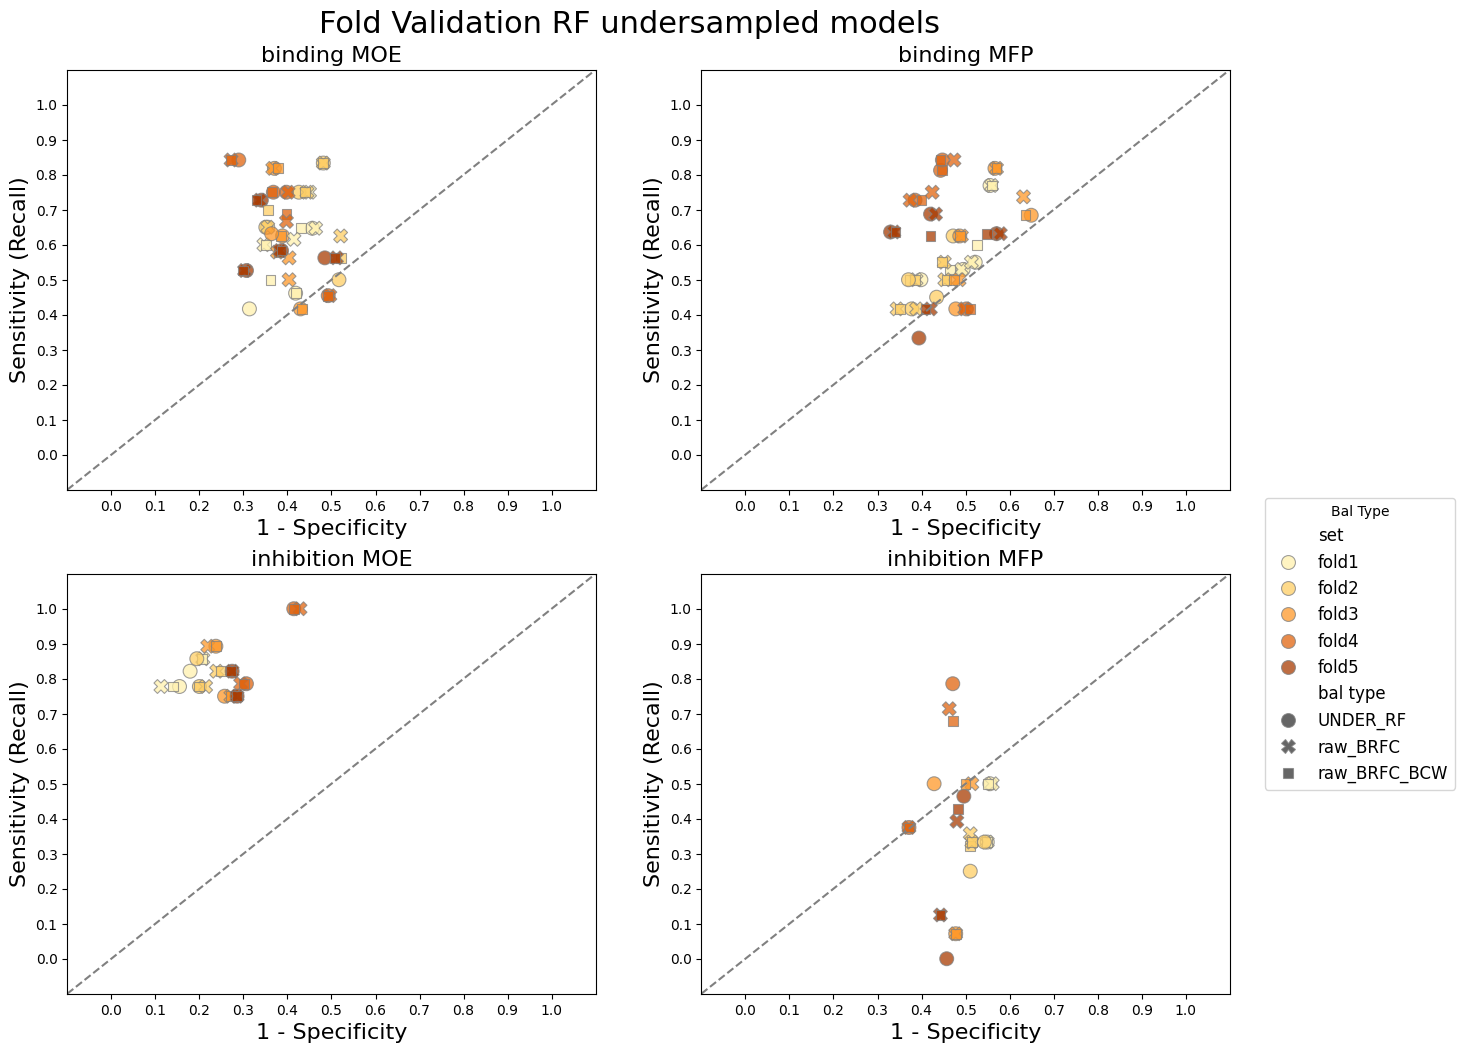

In [290]:
special_palette4 = {'raw_RF': 'cornflowerblue', 'raw_RF_BCW': 'cyan', 
                   'raw_BRFC': 'blue', 'raw_BRFC_BCW': 'black', 
                   'UNDER_RF': 'tab:orange', 'ADASYN_RF': 'tab:red', 
                   'raw_GP':'cornflowerblue', 'UNDER_GP':'tab:orange', 'ADASYN_GP':'tab:red' }
unique_cats = fold_bind['set'].nunique()
ylobr = sns.color_palette("YlOrBr", n_colors=unique_cats)
fig, axs = plt.subplots(2,2, figsize=(15,12))
for i, this_df in enumerate(list([fold_bind,fold_inhib])): 
    moe_df =this_df[this_df['feat_type'] == 'moe']
    mfp_df = this_df[this_df['feat_type'] == 'mfp']
    
    sns.scatterplot(data=moe_df, x='1-specificity', y='recall', hue='set',style='bal type',
                   alpha=0.75, palette=ylobr,s=100, edgecolor='gray', ax=axs[i,0])
    sns.scatterplot(data=mfp_df, x='1-specificity', y='recall', hue='set',style='bal type',
                   alpha=0.75, palette=ylobr,s=100,legend=True, ax=axs[i,1],edgecolor='gray')
    
    for j in range(2):  
        axs[i, j].plot([-0.1, 1.1], [-0.1, 1.1], linestyle='--', color='gray')
        axs[i, j].set_xlabel('1 - Specificity', fontsize=16)
        axs[i, j].set_ylabel('Sensitivity (Recall)', fontsize=16)
        axs[i, j].set_xlim(-0.1, 1.1)
        axs[i, j].set_ylim(-0.1, 1.1)
        axs[i, j].set_xticks(np.arange(0, 1.1, 0.1))
        axs[i, j].set_yticks(np.arange(0, 1.1, 0.1))
        axs[i, j].legend_.remove()
    axs[1,1].legend(title='Bal Type', fontsize=12,bbox_to_anchor=(1.05, 1.2))
    
    axs[i, 0].set_title(f'{moe_df["nek type"].iloc[0]} MOE', fontsize=16)
    axs[i, 1].set_title(f'{moe_df["nek type"].iloc[0]} MFP', fontsize=16)
plt.suptitle('Fold Validation RF undersampled models', fontsize=22, y=.93)
plt.savefig('fold1to5_undersampled_RF.png',bbox_inches='tight')

In [309]:
comparison_us['bal type'].value_counts()

bal type
UNDER_RF              12
raw_BRFC              12
raw_BRFC_fold5        12
UNDER_RF_fold5        12
raw_BRFC_BCW_fold4    12
raw_BRFC_fold4        12
UNDER_RF_fold4        12
raw_BRFC_BCW_fold3    12
raw_BRFC_fold3        12
UNDER_RF_fold3        12
raw_BRFC_BCW_fold2    12
raw_BRFC_fold2        12
UNDER_RF_fold2        12
raw_BRFC_BCW_fold1    12
raw_BRFC_fold1        12
UNDER_RF_fold1        12
raw_BRFC_BCW          12
raw_BRFC_BCW_fold5    12
Name: count, dtype: int64

raw_BRFC_fold1
raw_BRFC_fold2
raw_BRFC_fold3
raw_BRFC_fold4
raw_BRFC_fold5
raw_BRFC_BCW_fold1
raw_BRFC_BCW_fold2
raw_BRFC_BCW_fold3
raw_BRFC_BCW_fold4
raw_BRFC_BCW_fold5


/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_21657/138850008.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1,1].legend(title='Bal Type', fontsize=12,bbox_to_anchor=(1.05, 1.2))


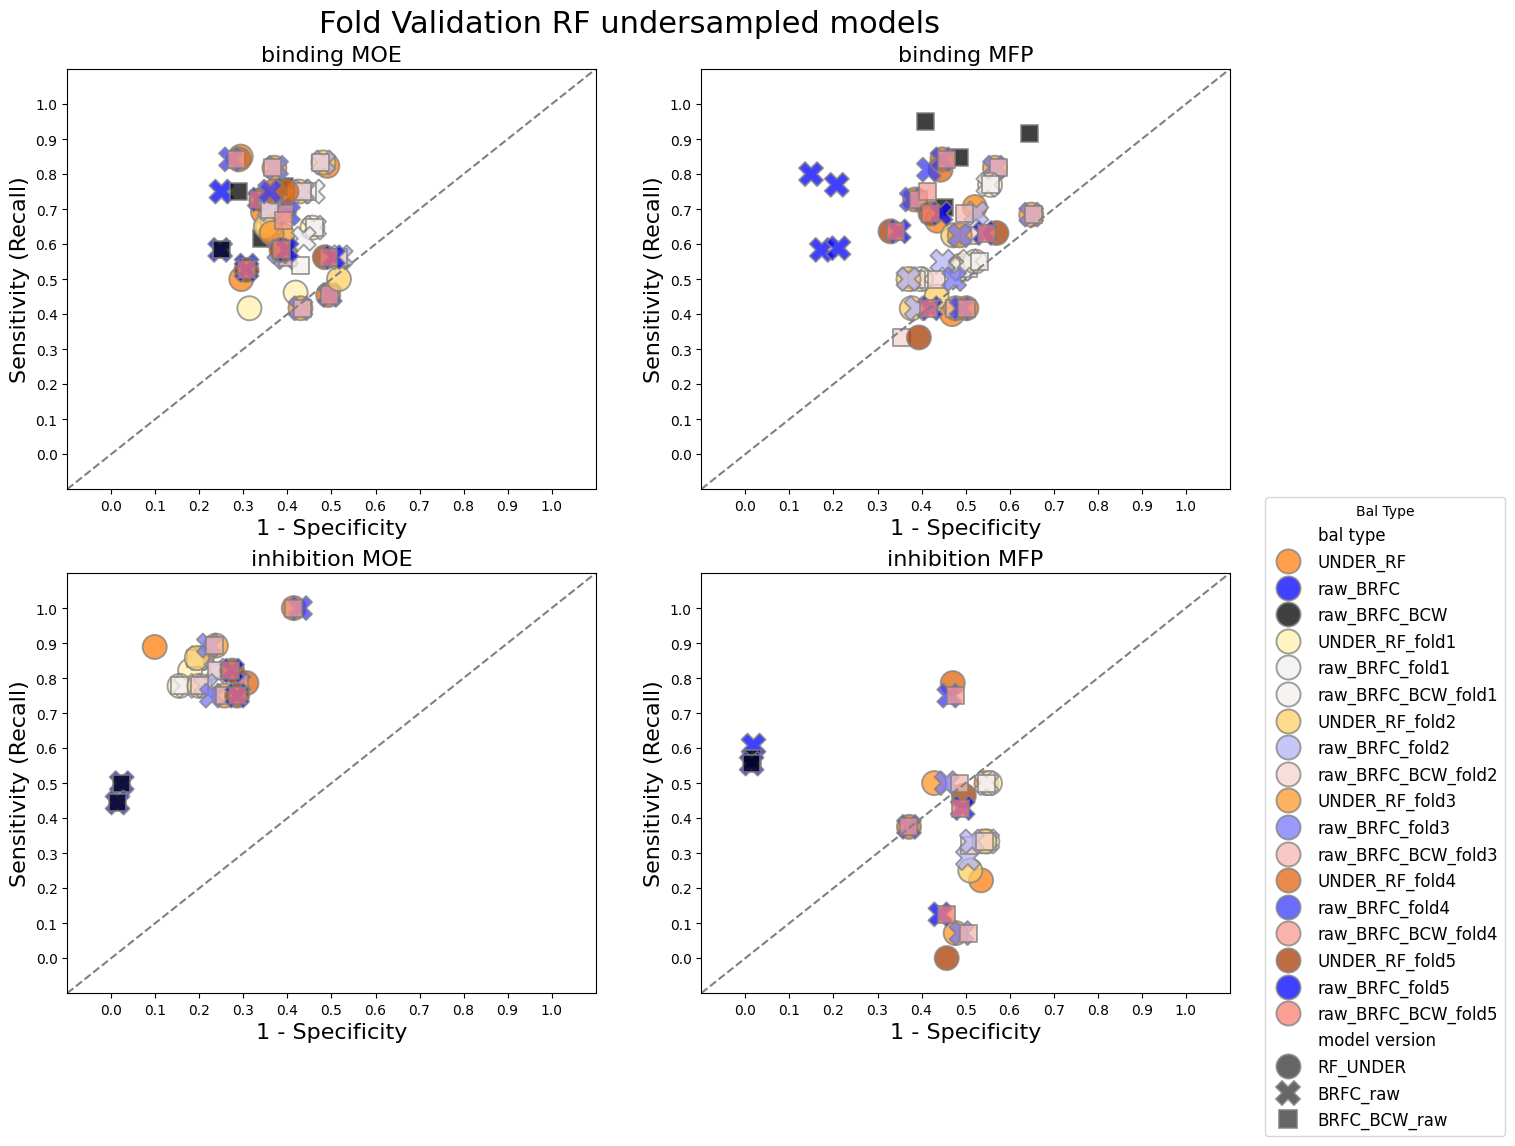

In [310]:
comparison_us['model version'] = comparison_us['RF_type'].astype(str)+'_'+comparison_us['strategy'] 
bind2 = comparison_us[comparison_us['nek type'] =='binding']
inhib2 = comparison_us[comparison_us['nek type'] =='inhibition'] 
special_palette5 = {'raw_RF': 'cornflowerblue', 'raw_RF_BCW': 'cyan', 
                   'raw_BRFC': 'blue', 'raw_BRFC_BCW': 'black', 
                   'UNDER_RF': 'tab:orange', 'ADASYN_RF': 'tab:red', 
                   'raw_GP':'cornflowerblue', 'UNDER_GP':'tab:orange', 'ADASYN_GP':'tab:red'}
comparison_us['bal type'].unique()
# lst_folds = ['UNDER_RF_fold3', 'raw_BRFC_fold3', 'UNDER_RF', 'raw_BRFC_fold2',
#        'raw_BRFC_BCW_fold2', 'raw_BRFC', 'raw_BRFC_BCW', 'UNDER_RF_fold1',
#        'raw_BRFC_fold1', 'raw_BRFC_BCW_fold1', 'UNDER_RF_fold2',
#        'raw_BRFC_BCW_fold3', 'UNDER_RF_fold4', 'raw_BRFC_fold4',
#        'raw_BRFC_BCW_fold4', 'UNDER_RF_fold5', 'raw_BRFC_fold5',
#        'raw_BRFC_BCW_fold5']
lst_folds = ['UNDER_RF_fold1', 'raw_BRFC_fold1', 'raw_BRFC_BCW_fold1','UNDER_RF_fold2', 'raw_BRFC_fold2', 'raw_BRFC_BCW_fold2', 
             'UNDER_RF_fold3', 'raw_BRFC_fold3', 'raw_BRFC_BCW_fold3', 'UNDER_RF_fold4', 'raw_BRFC_fold4', 'raw_BRFC_BCW_fold4',
             'UNDER_RF_fold5', 'raw_BRFC_fold5', 'raw_BRFC_BCW_fold5']
under_folds = ['UNDER_RF_fold1', 'UNDER_RF_fold2','UNDER_RF_fold3','UNDER_RF_fold4','UNDER_RF_fold5']
import matplotlib.colors as mcolors
yellows = sns.color_palette("YlOrBr", n_colors=5)
hex_colors_yellows = [mcolors.to_hex(color) for color in yellows]
under_folds = ['UNDER_RF_fold1','UNDER_RF_fold2','UNDER_RF_fold3','UNDER_RF_fold4','UNDER_RF_fold5']
for color,strat in zip(hex_colors_yellows,under_folds): 
    special_palette5[strat] = color 

BRFC_folds = ['raw_BRFC_fold1','raw_BRFC_fold2','raw_BRFC_fold3','raw_BRFC_fold4','raw_BRFC_fold5']
blues= sns.color_palette("light:b", n_colors=5)
hex_colors_BRFC = [mcolors.to_hex(color) for color in blues]
for color,strat in zip(hex_colors_BRFC,BRFC_folds): 
    print(strat)
    special_palette5[strat] = color 

BRFC_BCW_folds = ['raw_BRFC_BCW_fold1','raw_BRFC_BCW_fold2','raw_BRFC_BCW_fold3','raw_BRFC_BCW_fold4','raw_BRFC_BCW_fold5']
pinks = sns.color_palette("light:salmon", n_colors=5)
hex_colors_BRFC_BCW = [mcolors.to_hex(color) for color in pinks]
for color,strat in zip(hex_colors_BRFC_BCW,BRFC_BCW_folds): 
    print(strat)
    special_palette5[strat] = color 

fig, axs = plt.subplots(2,2, figsize=(15,12))
for i, this_df in enumerate(list([bind2,inhib2])): 
    moe_df =this_df[this_df['feat_type'] == 'moe']
    mfp_df = this_df[this_df['feat_type'] == 'mfp']
    
    sns.scatterplot(data=moe_df, x='1-specificity', y='recall', hue='bal type', style='model version',
                   alpha=0.75, palette=special_palette5,s=300, edgecolor='gray', ax=axs[i,0])
    sns.scatterplot(data=mfp_df, x='1-specificity', y='recall', hue='bal type',style='model version',
                   alpha=0.75, palette=special_palette5,s=300,legend=True, ax=axs[i,1],edgecolor='gray')
    
    for j in range(2):  
        axs[i, j].plot([-0.1, 1.1], [-0.1, 1.1], linestyle='--', color='gray')
        axs[i, j].set_xlabel('1 - Specificity', fontsize=16)
        axs[i, j].set_ylabel('Sensitivity (Recall)', fontsize=16)
        axs[i, j].set_xlim(-0.1, 1.1)
        axs[i, j].set_ylim(-0.1, 1.1)
        axs[i, j].set_xticks(np.arange(0, 1.1, 0.1))
        axs[i, j].set_yticks(np.arange(0, 1.1, 0.1))
        axs[i, j].legend_.remove()
    axs[1,1].legend(title='Bal Type', fontsize=12,bbox_to_anchor=(1.05, 1.2))
    
    axs[i, 0].set_title(f'{moe_df["nek type"].iloc[0]} MOE', fontsize=16)
    axs[i, 1].set_title(f'{moe_df["nek type"].iloc[0]} MFP', fontsize=16)
plt.suptitle('Fold Validation RF undersampled models', fontsize=22, y=.93)
plt.savefig('fold1to5_undersampled_all_RFtypes.png',bbox_inches='tight')

# try just RF models 


/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_21657/1515452266.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1,1].legend(title='Bal Type', fontsize=12,bbox_to_anchor=(1.05, 1.2))


Text(0.5, 0.93, 'Fold Validation RF undersampled models')

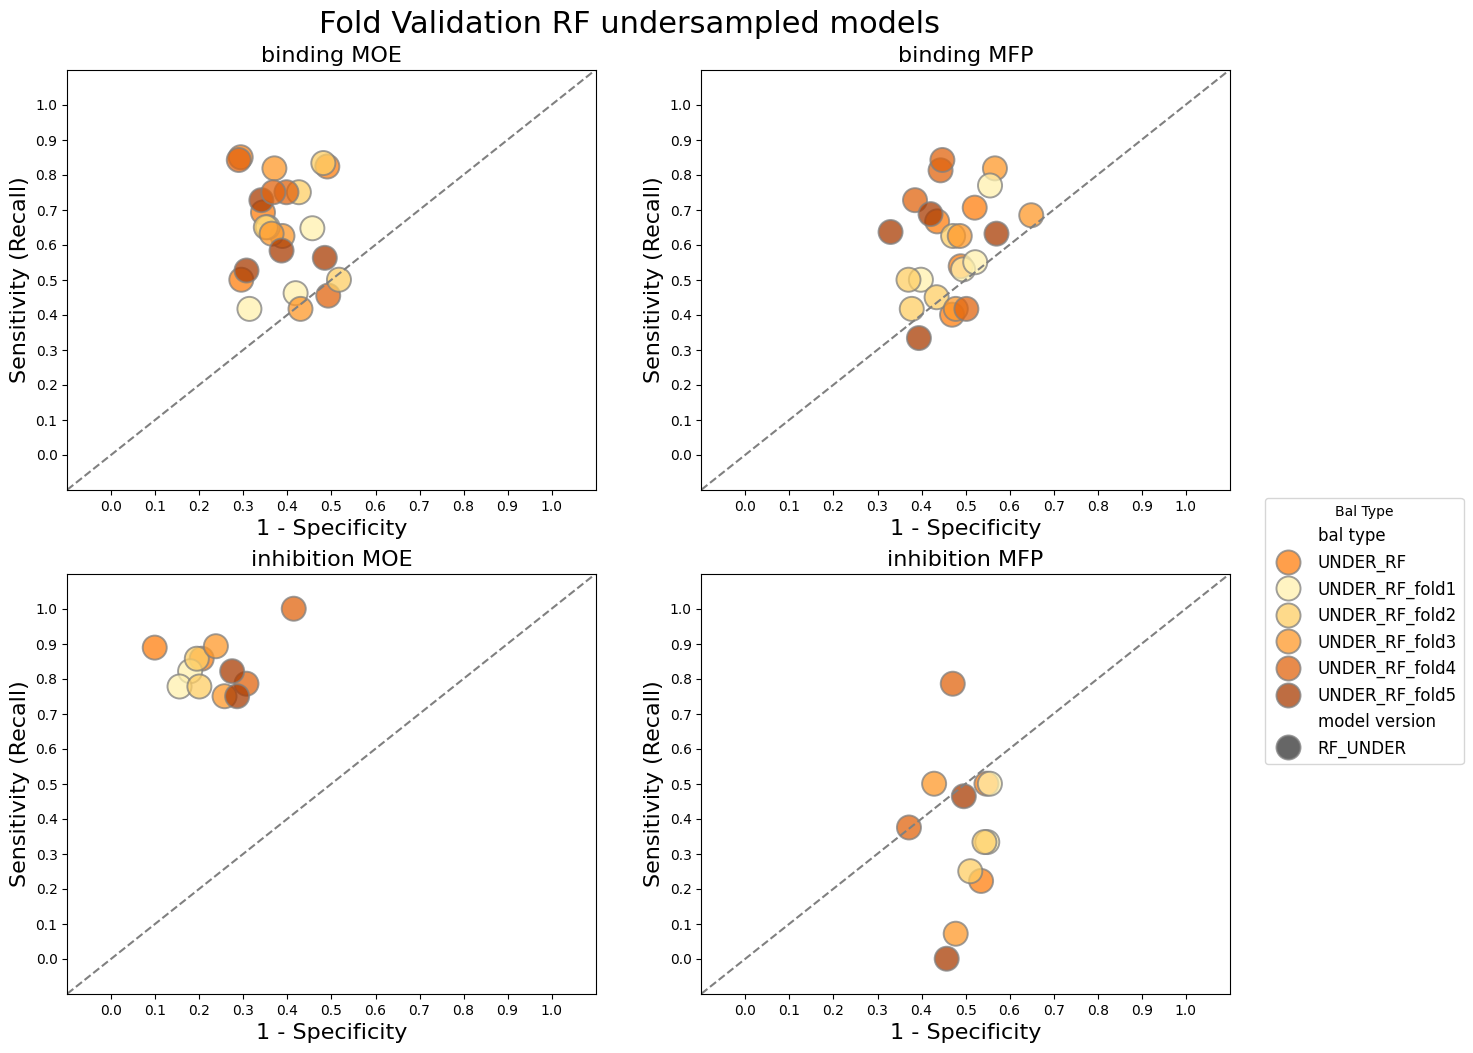

In [318]:
fig, axs = plt.subplots(2,2, figsize=(15,12))
for i, this_df in enumerate(list([bind2,inhib2])): 
    this_df = this_df[this_df['RF_type'] =='RF']
    moe_df =this_df[this_df['feat_type'] == 'moe']
    mfp_df = this_df[this_df['feat_type'] == 'mfp']
    # print('moe') 
    # print(moe_df['bal type'].value_counts())
    # print('mfp') 
    # print(mfp_df['bal type'].value_counts())
    sns.scatterplot(data=moe_df, x='1-specificity', y='recall', hue='bal type', style='model version',
                   alpha=0.75, palette=special_palette5,s=300, edgecolor='gray', ax=axs[i,0])
    sns.scatterplot(data=mfp_df, x='1-specificity', y='recall', hue='bal type',style='model version',
                   alpha=0.75, palette=special_palette5,s=300,legend=True, ax=axs[i,1],edgecolor='gray')
    
    for j in range(2):  
        axs[i, j].plot([-0.1, 1.1], [-0.1, 1.1], linestyle='--', color='gray')
        axs[i, j].set_xlabel('1 - Specificity', fontsize=16)
        axs[i, j].set_ylabel('Sensitivity (Recall)', fontsize=16)
        axs[i, j].set_xlim(-0.1, 1.1)
        axs[i, j].set_ylim(-0.1, 1.1)
        axs[i, j].set_xticks(np.arange(0, 1.1, 0.1))
        axs[i, j].set_yticks(np.arange(0, 1.1, 0.1))
        axs[i, j].legend_.remove()
    axs[1,1].legend(title='Bal Type', fontsize=12,bbox_to_anchor=(1.05, 1.2))
    
    axs[i, 0].set_title(f'{moe_df["nek type"].iloc[0]} MOE', fontsize=16)
    axs[i, 1].set_title(f'{moe_df["nek type"].iloc[0]} MFP', fontsize=16)
plt.suptitle('Fold Validation RF undersampled models', fontsize=22, y=.93)
# plt.savefig('fold1to5_undersampled_all_RFtypes.png',bbox_inches='tight')

# BRFC

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_21657/2310725070.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1,1].legend(title='Bal Type', fontsize=12,bbox_to_anchor=(1.05, 1.2))


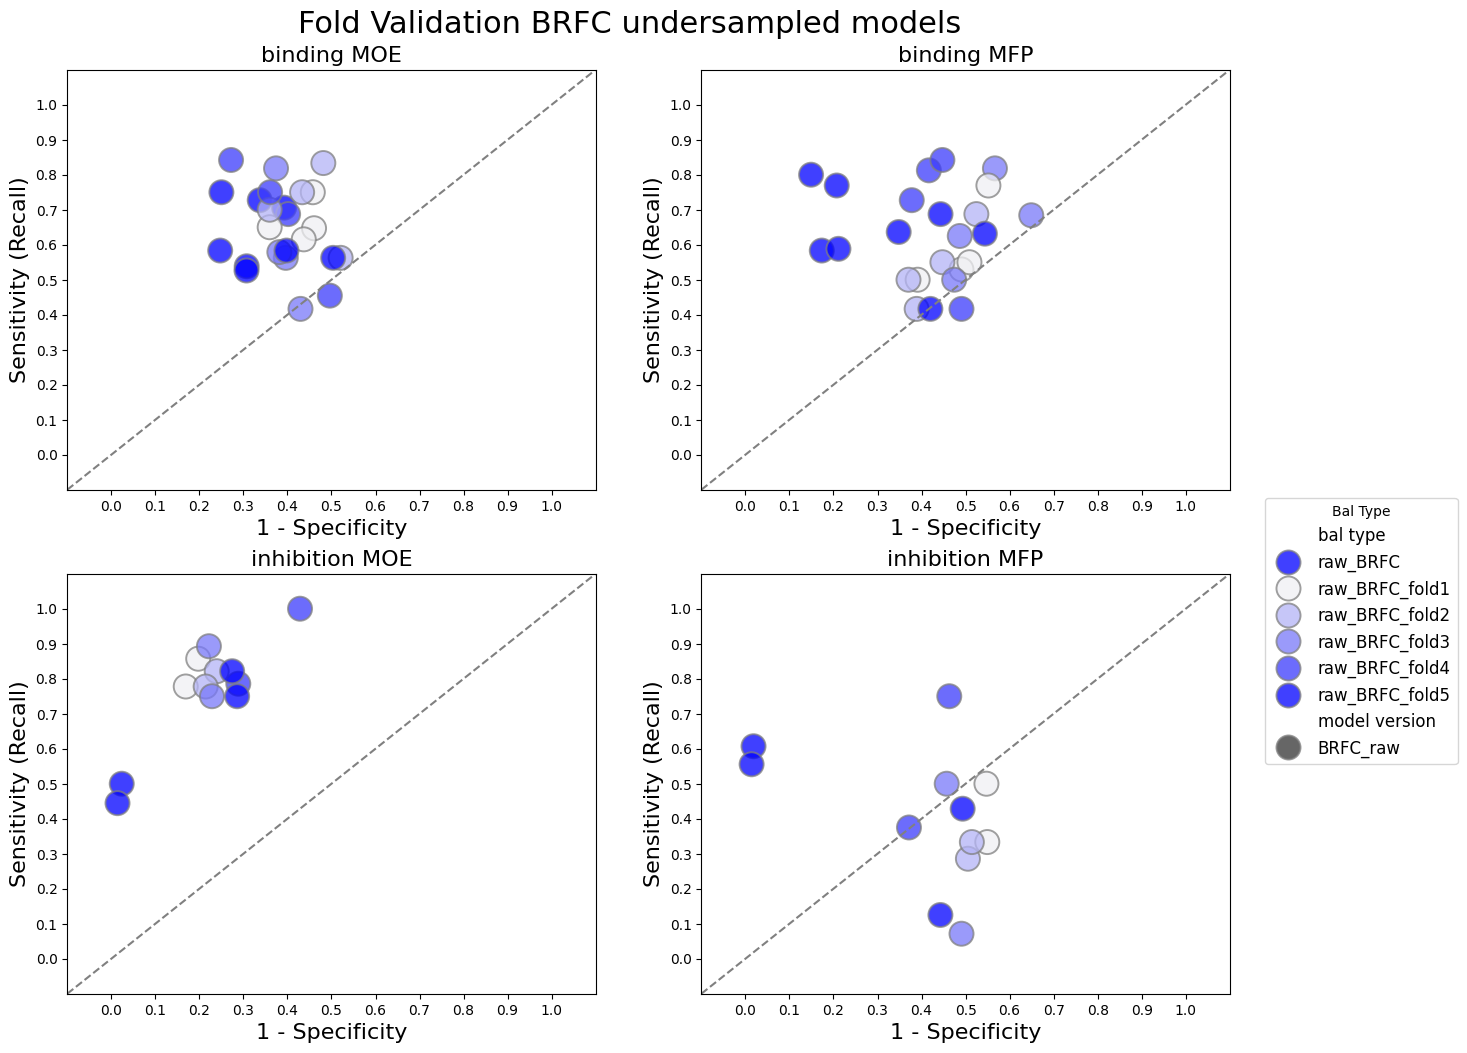

In [317]:
fig, axs = plt.subplots(2,2, figsize=(15,12))
for i, this_df in enumerate(list([bind2,inhib2])): 
    this_df = this_df[this_df['RF_type'] =='BRFC']
    moe_df =this_df[this_df['feat_type'] == 'moe']
    mfp_df = this_df[this_df['feat_type'] == 'mfp']
    # print('moe') 
    # print(moe_df['bal type'].value_counts())
    # print('mfp') 
    # print(mfp_df['bal type'].value_counts())
    sns.scatterplot(data=moe_df, x='1-specificity', y='recall', hue='bal type', style='model version',
                   alpha=0.75, palette=special_palette5,s=300, edgecolor='gray', ax=axs[i,0])
    sns.scatterplot(data=mfp_df, x='1-specificity', y='recall', hue='bal type',style='model version',
                   alpha=0.75, palette=special_palette5,s=300,legend=True, ax=axs[i,1],edgecolor='gray')
    
    for j in range(2):  
        axs[i, j].plot([-0.1, 1.1], [-0.1, 1.1], linestyle='--', color='gray')
        axs[i, j].set_xlabel('1 - Specificity', fontsize=16)
        axs[i, j].set_ylabel('Sensitivity (Recall)', fontsize=16)
        axs[i, j].set_xlim(-0.1, 1.1)
        axs[i, j].set_ylim(-0.1, 1.1)
        axs[i, j].set_xticks(np.arange(0, 1.1, 0.1))
        axs[i, j].set_yticks(np.arange(0, 1.1, 0.1))
        axs[i, j].legend_.remove()
    axs[1,1].legend(title='Bal Type', fontsize=12,bbox_to_anchor=(1.05, 1.2))
    
    axs[i, 0].set_title(f'{moe_df["nek type"].iloc[0]} MOE', fontsize=16)
    axs[i, 1].set_title(f'{moe_df["nek type"].iloc[0]} MFP', fontsize=16)
plt.suptitle('Fold Validation BRFC undersampled models', fontsize=22, y=.93)
plt.savefig('fold1to5_undersampled_BRFC.png',bbox_inches='tight')

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_21657/26786098.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1,1].legend(title='Bal Type', fontsize=12,bbox_to_anchor=(1.05, 1.2))


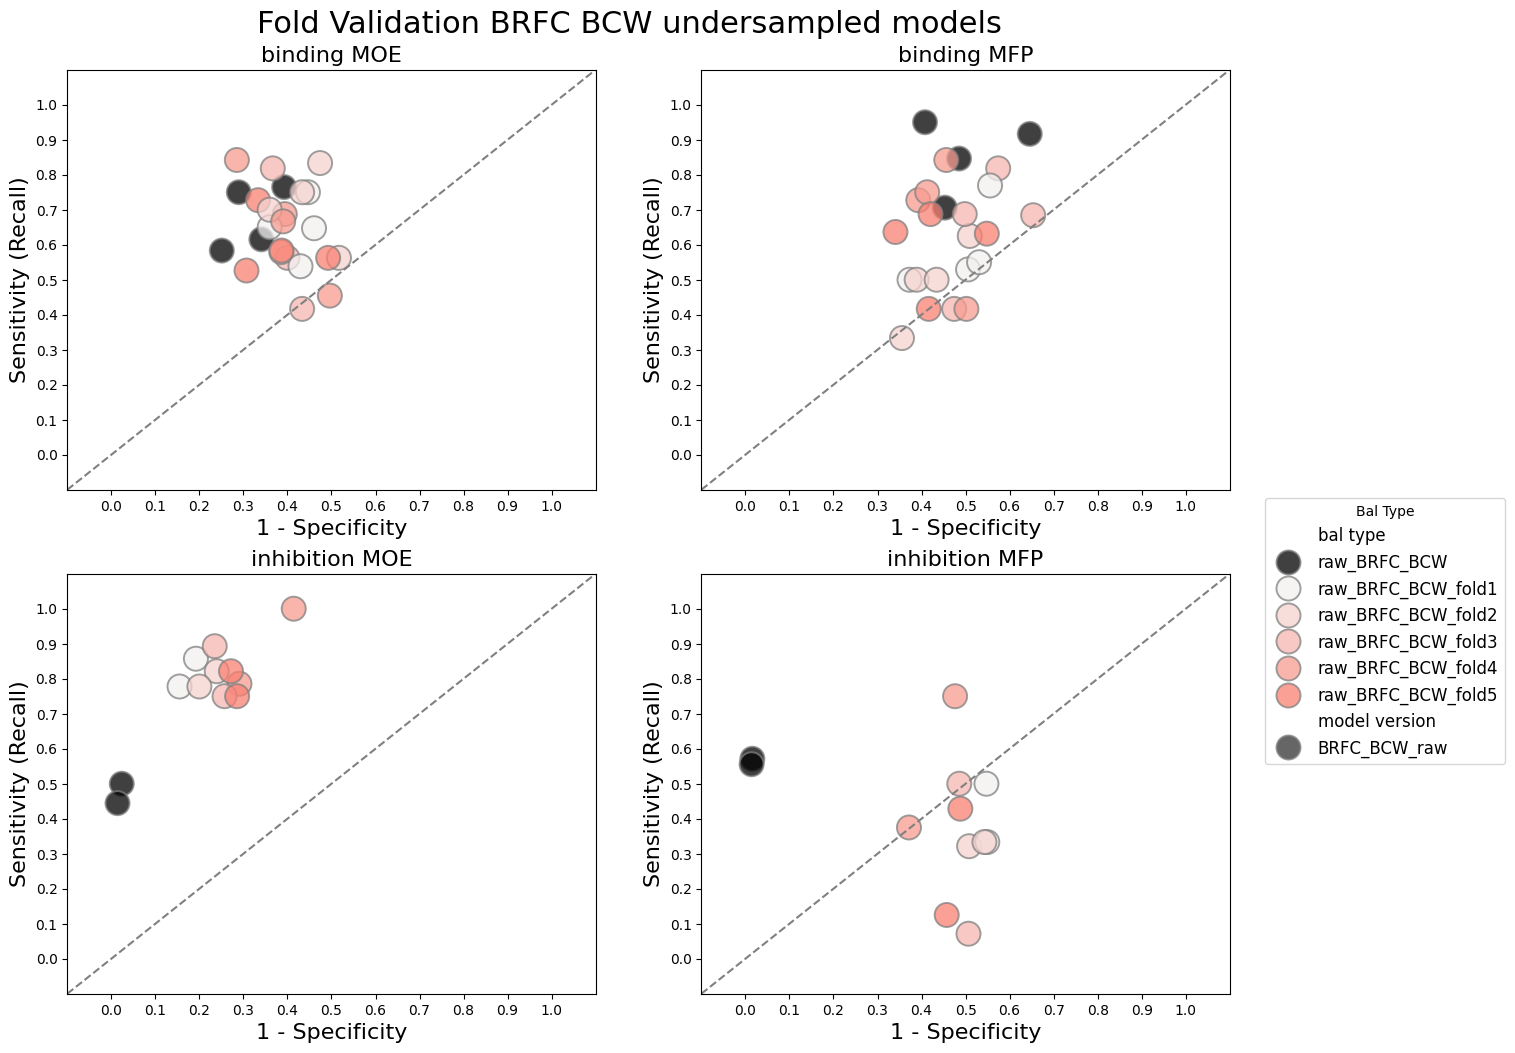

In [320]:
fig, axs = plt.subplots(2,2, figsize=(15,12))
for i, this_df in enumerate(list([bind2,inhib2])): 
    this_df = this_df[this_df['RF_type'] =='BRFC_BCW']
    moe_df =this_df[this_df['feat_type'] == 'moe']
    mfp_df = this_df[this_df['feat_type'] == 'mfp']
    # print('moe')
    # print(moe_df['bal type'].value_counts())
    # print('mfp')
    # print(mfp_df['bal type'].value_counts())
    
    sns.scatterplot(data=moe_df, x='1-specificity', y='recall', hue='bal type', style='model version',
                   alpha=0.75, palette=special_palette5,s=300, edgecolor='gray', ax=axs[i,0])
    sns.scatterplot(data=mfp_df, x='1-specificity', y='recall', hue='bal type',style='model version',
                   alpha=0.75, palette=special_palette5,s=300,legend=True, ax=axs[i,1],edgecolor='gray')
    
    for j in range(2):  
        axs[i, j].plot([-0.1, 1.1], [-0.1, 1.1], linestyle='--', color='gray')
        axs[i, j].set_xlabel('1 - Specificity', fontsize=16)
        axs[i, j].set_ylabel('Sensitivity (Recall)', fontsize=16)
        axs[i, j].set_xlim(-0.1, 1.1)
        axs[i, j].set_ylim(-0.1, 1.1)
        axs[i, j].set_xticks(np.arange(0, 1.1, 0.1))
        axs[i, j].set_yticks(np.arange(0, 1.1, 0.1))
        axs[i, j].legend_.remove()
    axs[1,1].legend(title='Bal Type', fontsize=12,bbox_to_anchor=(1.05, 1.2))
    
    axs[i, 0].set_title(f'{moe_df["nek type"].iloc[0]} MOE', fontsize=16)
    axs[i, 1].set_title(f'{moe_df["nek type"].iloc[0]} MFP', fontsize=16)
plt.suptitle('Fold Validation BRFC BCW undersampled models', fontsize=22, y=.93)
plt.savefig('fold1to5_undersampled_BRFC_BCW.png',bbox_inches='tight')